## Data Understanding

1. Import Libraries

In [1]:
import pandas as pd

#pd.set_option('display.max_colwidth', None)
# use to view full tweet context

In [2]:
tweets = pd.read_csv('judge_tweet_product_company.csv',encoding='ISO-8859-1')
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
tweets.shape

(9093, 3)

In [5]:
tweets.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
tweets.duplicated().sum()

np.int64(22)

## Data Cleaning
 1. Import Libraries:

In [7]:
import re
import numpy as np

In [8]:
# Rename the columns 
tweets.rename(columns={
    'tweet_text': 'text',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}, inplace=True)

### Emotion column cleaning

In [9]:
# Check unique values
emotions = tweets['emotion'].unique()
print("Emotions:", emotions)

Emotions: ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]


In [10]:
# Print value counts for the 'emotion' column
print(tweets['emotion'].value_counts())

emotion
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


To clean the emotion column for easier handling, we can simplify these categories to make analysis more straightforward. 

Combine Ambiguous Emotions: Group the categories for ambiguous or neutral responses, such as "No emotion toward brand or product" and "I can't tell," into a single category, "Neutral".

Label Encoding: Assign numerical values to each category for better compatibility with machine learning models (e.g., -1 for "Negative," 0 for "Neutral," and 1 for "Positive").

Map to Simple Labels: Shorten each category name for easier interpretation, like:

"Positive" for "Positive emotion"
"Negative" for "Negative emotion"
"Neutral" for "No emotion toward brand or product" and "I can't tell"


In [11]:
# Define a mapping dictionary to simplify the emotion categories
emotion_mapping = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral',
    "I can't tell": 'Neutral'
}

# Apply the mapping to the emotion column
tweets['emotion'] = tweets['emotion'].map(emotion_mapping)

# Check the value counts to confirm changes
print(tweets['emotion'].value_counts())


emotion
Neutral     5545
Positive    2978
Negative     570
Name: count, dtype: int64


### Product Column cleaning

In [12]:
# Find the records with missing values in the column
tweets[tweets['product'].isnull() == True].shape[0]

5802

So we will try check the text column with reference to the unique vaues in the product column, and fill the product column missing values with the product names described from the unique list. 
we want to have a larger dataset for more significant sentiment analysis

In [13]:
# List of unique products/services,
products = list(tweets['product'].unique())

# Define a regex pattern for any product
pattern = re.compile(r'\b(' + '|'.join(re.escape(str(p)) for p in products) + r')\b', re.IGNORECASE)

# c
def find_product_with_regex(tweet):
    # Check if the tweet is a string before performing regex search
    if isinstance(tweet, str):
        match = pattern.search(tweet)
        if match:
            return match.group(0)
    return np.nan  # Return NaN if no product is found

# Apply the function to fill missing values in 'product' column
tweets['product'] = tweets['product'].fillna(tweets['text'].apply(find_product_with_regex))

In [14]:
# Check for any remaining null values in the 'product' column
tweets[tweets['product'].isnull() == True].shape[0]

796

In the tweets dataset, some rows have missing values in the product column, which we previously attempted to populate with the names of products mentioned in each tweet. These missing values are likely from tweets that don’t mention any specific product or where we couldn't detect a product name due to variations in spelling or phrasing.

To handle these missing entries, we chose to impute them with the label 'unknown'. This approach allows us to retain these rows in the dataset rather than dropping them, which would reduce our sample size and potentially lead to a loss of valuable contextual information.

In [15]:
# lets fill the NaN values with unknown to change to string
tweets['product'] = tweets['product'].fillna('unknown')

In [16]:
# Check unique values
unique_products = tweets['product'].unique()
print("Unique products:", unique_products)

Unique products: ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' 'unknown' 'Android' 'Apple'
 'Android App' 'Other Google product or service' 'ipad' 'google' 'APPLE'
 'apple' 'android' 'iphone' 'IPad' 'Other Apple product or service'
 'IPhone' 'GOOGLE' 'Ipad' 'Iphone' 'IPAD' 'iPAD' 'iPHONE' 'ANDROID']


With the various products it would be benefitial to categorize them to three groups, this wold allow classify new products to the category and be aware of the brand comparison in terms of the products each offer

 - We start by defining two lists, apple_products and google_products, each containing names of well-known products associated with Apple and Google, respectively
 - These lists allow the program to check for matches against a known set of brand products
 - We convert all values in the product column to lowercase
- Define a function to to check the product and compares with the apple products or google products list.
- Match the apppriate product to each category if "unknown" is encoutered it should go to the other category.

In [17]:
def categorize_product(product):
    # List of keywords for classification
    apple_keywords = ['iphone', 'ipad', 'mac', 'ios', 'apple', 'ipad or iphone app', 'apple product', 'other apple product']
    google_keywords = ['google', 'android', 'google product', 'android app', 'other google product']

    # Lowercase the product for consistent matching
    product = product.lower()
    
    # Initialize category as 'other'
    category = 'other'
    
    # Check for Apple-related keywords
    for keyword in apple_keywords:
        if keyword in product:
            category = 'apple'
            break

    # Check for Google-related keywords
    for keyword in google_keywords:
        if keyword in product:
            category = 'google'
            break

    return category

# Apply the new categorization function
tweets['product_category'] = tweets['product'].apply(categorize_product)

# Print value counts for the 'product_category' column
print(tweets['product_category'].value_counts())


product_category
apple     5436
google    2861
other      796
Name: count, dtype: int64


In [18]:
# Check only 'unknown' products are categorized as 'other'
other_category_products = tweets[tweets['product_category'] == 'other']['product']
print(other_category_products.unique())

['unknown']


In [19]:
tweets.head()

,text,product,emotion,product_category
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,google


### Text Column cleaning

In [20]:
# lets drop the null value in text column
tweets.dropna(subset=['text'], inplace=True)

In [21]:
 # Remove non-ASCII characters in the text column
tweets['text'] = tweets['text'].apply(lambda x: ''.join([char for char in str(x) if ord(char) < 128]))

In [22]:
# # Function to clean up text
# def clean_text(text):
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#     # Remove user @ mentions
#     text = re.sub(r'@\w+', '', text)
#     # Remove hashtags
#     text = re.sub(r'#\w+', '', text)
#     # Remove punctuation and numbers
#     text = re.sub(r'[^A-Za-z\s]', '', text)
#     # Remove extra whitespace
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text

# tweets['text'] = tweets['text'].apply(clean_text)


In [23]:
# # Convert text to lowercase
# tweets['text'] = tweets['text'].str.lower()

## Univariate Analysis

Import libraries

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

Univariate analysis examines individual columns to understand their distributions and characteristics.

+ Distribution of product_category: This helps understand the frequency of each category (Apple, Google, and Other).
+ Distribution of emotion: This shows how positive and negative emotions are distributed across the dataset.
+ Text Analysis: We can analyze the frequency of words in the text column to identify common terms.

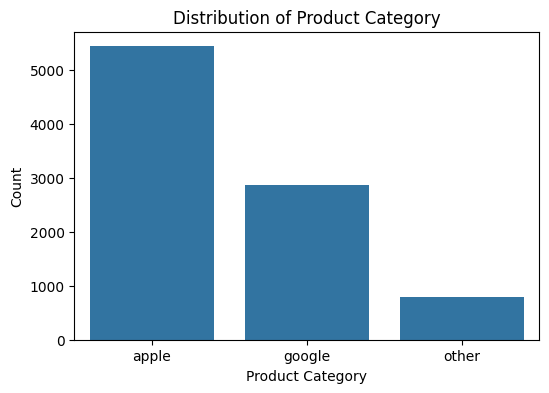

In [25]:
# Countplot for product category
plt.figure(figsize=(6, 4))
sns.countplot(x='product_category', data=tweets)
plt.title('Distribution of Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()


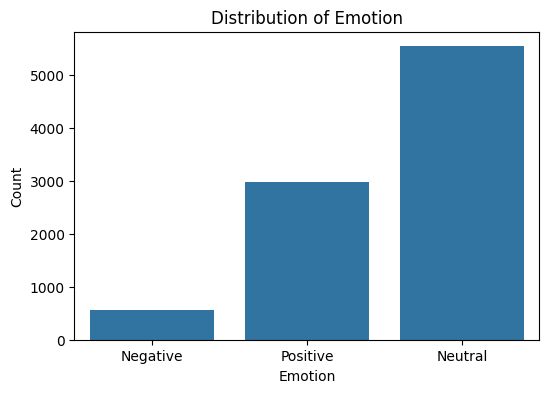

In [26]:
# Countplot for emotion
plt.figure(figsize=(6, 4))
sns.countplot(x='emotion', data=tweets)
plt.title('Distribution of Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


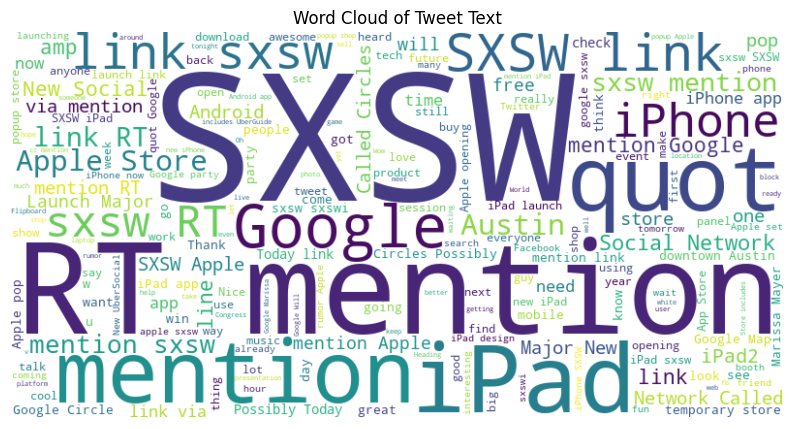

In [27]:
# Join all the tweets into one large string
text_data = ' '.join(tweets['text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()


## Bivariate Analysis

### Product Category vs. Emotion

This analysis shows if certain product categories are associated with more positive or negative emotions.

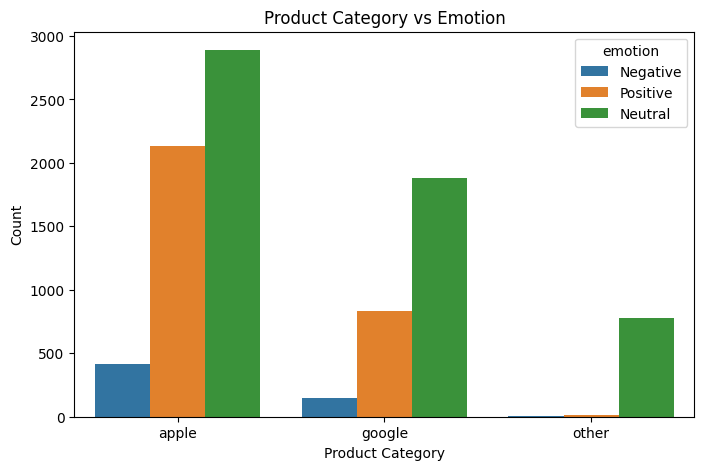

In [28]:
# Countplot for product category vs emotion
plt.figure(figsize=(8, 5))
sns.countplot(x='product_category', hue='emotion', data=tweets)
plt.title('Product Category vs Emotion')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()


### Product Category vs. Product
This analysis will help see which specific products fall under each category.

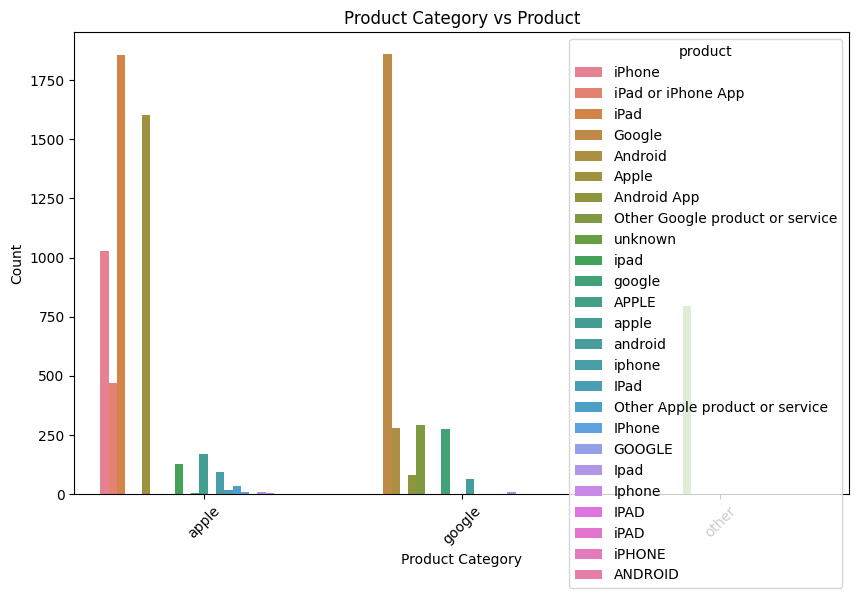

In [29]:
# Countplot for product category vs product
plt.figure(figsize=(10, 6))
sns.countplot(x='product_category', hue='product', data=tweets)
plt.title('Product Category vs Product')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()
